In [1]:
from pyoculus.problems import AnalyticCylindricalBfield
from pyoculus.solvers import PoincarePlot, FixedPoint, Manifold
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [2]:
### Creating the pyoculus problem object
print("\nCreating the pyoculus problem object\n")

separatrix = {"type": "circular-current-loop", "amplitude": -10, "R": 6, "Z": -5.5}
maxwellboltzmann = {"m": 13, "n": -2, "d": np.sqrt(2), "type": "maxwell-boltzmann", "amplitude": 1e-7}

# Creating the pyoculus problem object, adding the perturbation here use the R, Z provided as center point
pyoproblem = AnalyticCylindricalBfield.without_axis(
    6,
    0,
    0.91,
    0.6,
    perturbations_args=[separatrix],
    Rbegin=1,
    Rend=8,
    niter=800,
    guess=[6.41, -0.7],
    tol=1e-9,
)

# # Adding perturbation after the object is created uses the found axis as center point
pyoproblem.add_perturbation(maxwellboltzmann)


Creating the pyoculus problem object

0 - dr : 0.010422282084041626
1 - RZ : [ 6.41409394 -0.69368043]
1 - dr : 6.293042617861982e-06
2 - RZ : [ 6.41409781 -0.69367863]
2 - dr : 9.774877130901314e-12
0 - dr : 9.774877130901314e-12


In [3]:
### Finding the X-point
print("\nFinding the X-point\n")

# set up the integrator for the FixedPoint
iparams = dict()
iparams["rtol"] = 1e-12

pparams = dict()
pparams["nrestart"] = 0
pparams["niter"] = 300

# set up the FixedPoint object
fixedpoint = FixedPoint(pyoproblem, pparams, integrator_params=iparams)

# find the X-point
# guess = [6.18, -4.49]
guess = [6.21560891, -4.46981856]
print(f"Initial guess: {guess}")

fixedpoint.compute(guess=guess, pp=0, qq=1, sbegin=4, send=9, tol=1e-10)

if fixedpoint.successful:
    results = [list(p) for p in zip(fixedpoint.x, fixedpoint.y, fixedpoint.z)]
else:
    print("FixedPoint did not converge - don't continue")


Finding the X-point

Initial guess: [6.21560891, -4.46981856]
0 - [DeltaR, DeltaZ] : [1.64340621e-08 2.01978674e-08] - dtheta : 4.0578254090206656e-09
0 - [StepR, StepZ]: [-3.75411258e-09  4.86722129e-09]
1 - RZ : [ 6.21560891 -4.46981856] - rhotheta : [ 3.78135301 -1.62331197]
1 - [DeltaR, DeltaZ] : [-8.88178420e-14 -6.75015599e-14] - dtheta : 1.9024781749976682e-12


(3.5, 9.2)

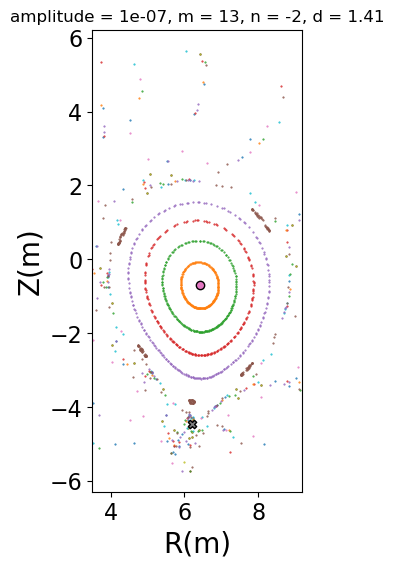

In [72]:
fig = pickle.load(open("../../runs/toybox-tok-1704/perturbed-13-2/poincare_04181732.pkl", "rb"))
ax = fig.gca()
ax.set_xlim(3.5, 9.2)

In [4]:
iparams = dict()
iparams["rtol"] = 1e-12

manifold = Manifold(fixedpoint, pyoproblem, integrator_params=iparams)

In [5]:
manifold.choose()

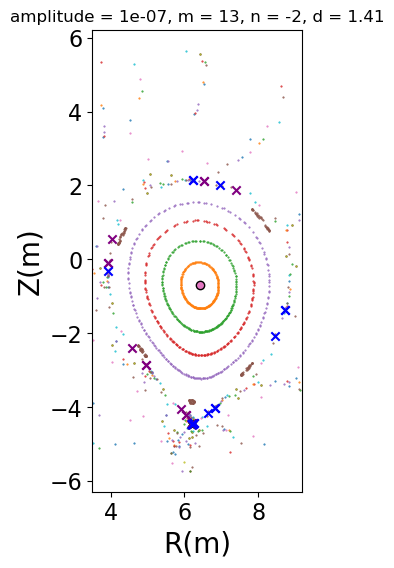

In [32]:
hs = manifold.integrate(manifold.rfp_s + 1e-6 * manifold.vector_s, 7, -1)
hu = manifold.integrate(manifold.rfp_u + 1e-6 * manifold.vector_u, 6, 1)

ax.scatter(hs[0,:], hs[1,:], marker="x", color="purple", zorder=10)
ax.scatter(hu[0,:], hu[1,:], marker="+", color="blue", zorder=10)

fig

In [13]:
from scipy.optimize import fsolve

def find_homoclinic(self, guess_eps_s = 1e-3, guess_eps_u = 1e-3, **kwargs):
        defaults = {"maxiter": 100, "n_s": None, "n_u": None, "N_return": None}
        defaults.update({key: value for key, value in kwargs.items() if key in defaults})

        if defaults['n_s'] is None or defaults['n_u'] is None:
            n_s, n_u = self.find_N(guess_eps_s, guess_eps_u)
            print(f"Found [n_s, n_u] : [{n_s}, {n_u}]")
        else:
            n_s, n_u = defaults['n_s'], defaults['n_u']

        if defaults['N_return'] is None:
            defaults['N_return'] = max(n_s, n_u)

        def evolution(eps, n_s, n_u):
            eps_s, eps_u = eps
            r_s = self.rfp_s + eps_s * self.vector_s
            r_u = self.rfp_u + eps_u * self.vector_u

            r_s_evolved, jac_s = self.integrate_single(r_s, n_s, -1)
            r_u_evolved, jac_u = self.integrate_single(r_u, n_u, 1)

            return r_s_evolved - r_u_evolved, np.array([jac_s @ self.vector_s, -jac_u @ self.vector_u])
        
        def residual(eps, n_s, n_u):
            return evolution(eps, n_s, n_u)[0]

        def jacobian(eps, n_s, n_u):
            return evolution(eps, n_s, n_u)[1]
        
        eps_s_1, eps_u_1 = fsolve(residual, [guess_eps_s, guess_eps_u], args=(n_s, n_u), fprime=jacobian)
        print(f"Eps 1: {eps_s_1}, {eps_u_1}")
        if eps_s_1 < 0 or eps_u_1 < 0:
            raise ValueError("Homoclinic point epsilon cannot be negative.")

        return eps_s_1, eps_u_1

In [26]:
eps_s_1, eps_u_1 = find_homoclinic(manifold, 1e-6, 1e-6, n_s = 7, n_u = 6)

Eps 1: 1.1134743483282775e-06, 7.257282658586981e-07


In [28]:
guess_2 = [eps_s_1*np.power(manifold.lambda_s, 1/4), eps_u_1*np.power(manifold.lambda_u, 1/4)]     
print(f"Initial guess: {guess_2}")   

Initial guess: [4.770809230707356e-07, 1.6938002942753848e-06]


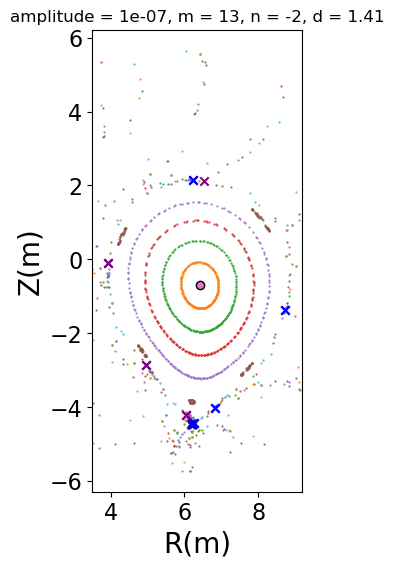

In [36]:
hs = manifold.integrate(manifold.rfp_s + guess_2[0] * manifold.vector_s, 7, -1)
hu = manifold.integrate(manifold.rfp_u + guess_2[1] * manifold.vector_u, 6, 1)

ax.scatter(hs[0,:], hs[1,:], marker="x", color="purple", zorder=10)
ax.scatter(hu[0,:], hu[1,:], marker="+", color="blue", zorder=10)

fig

In [37]:
eps_s_2, eps_u_2 = find_homoclinic(manifold, guess_2[0], guess_2[1], n_s = 7, n_u = 6)

Eps 1: 3.947839945223649e-07, 1.6729243920931443e-06


In [38]:
guess_3 = [eps_s_1*np.power(manifold.lambda_s, 2/4), eps_u_1*np.power(manifold.lambda_u, 2/4)]     
print(f"Initial guess: {guess_3}")   

Initial guess: [2.0441082230564478e-07, 3.9532144080026456e-06]


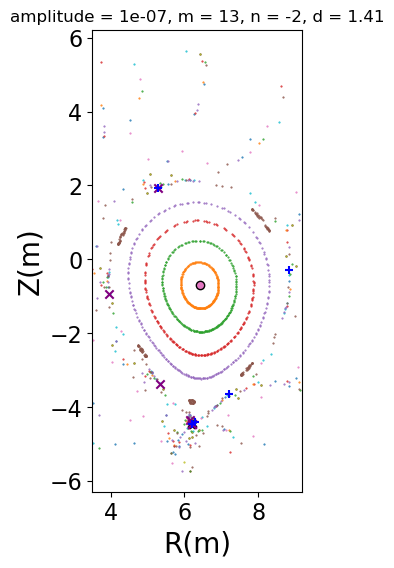

In [51]:
hs = manifold.integrate(manifold.rfp_s + guess_3[0] * manifold.vector_s, 7, -1)
hu = manifold.integrate(manifold.rfp_u + guess_3[1] * manifold.vector_u, 6, 1)

ax.scatter(hs[0,:], hs[1,:], marker="x", color="purple", zorder=10)
ax.scatter(hu[0,:], hu[1,:], marker="+", color="blue", zorder=10)

# ax.set_xlim(5.27, 5.3)
# ax.set_ylim(1.85, 2)

fig

In [52]:
eps_s_3, eps_u_3 = find_homoclinic(manifold, guess_3[0], guess_3[1], n_s = 7, n_u = 6) 

Eps 1: 2.0441093372206892e-07, 3.953205308047722e-06


In [53]:
guess_4 = [eps_s_1*np.power(manifold.lambda_s, 3/4), eps_u_1*np.power(manifold.lambda_u, 3/4)]     
print(f"Initial guess: {guess_4}") 

Initial guess: [8.758217370488887e-08, 9.226532908547754e-06]


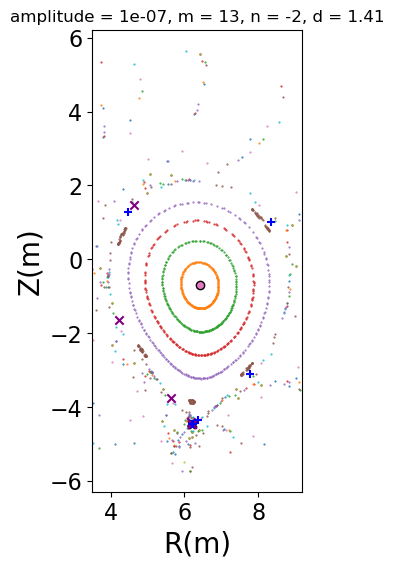

In [55]:
hs = manifold.integrate(manifold.rfp_s + guess_4[0] * manifold.vector_s, 7, -1)
hu = manifold.integrate(manifold.rfp_u + guess_4[1] * manifold.vector_u, 6, 1)

ax.scatter(hs[0,:], hs[1,:], marker="x", color="purple", zorder=10)
ax.scatter(hu[0,:], hu[1,:], marker="+", color="blue", zorder=10)

fig

In [56]:
eps_s_4, eps_u_4 = find_homoclinic(manifold, guess_4[0], guess_4[1], n_s = 7, n_u = 6)

Eps 1: 7.198819502631896e-08, 9.253697506264997e-06


C:\Users\Ludovic\AppData\Local\Temp\ipykernel_31760\1942692715.py:32: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  eps_s_1, eps_u_1 = fsolve(residual, [guess_eps_s, guess_eps_u], args=(n_s, n_u), fprime=jacobian)


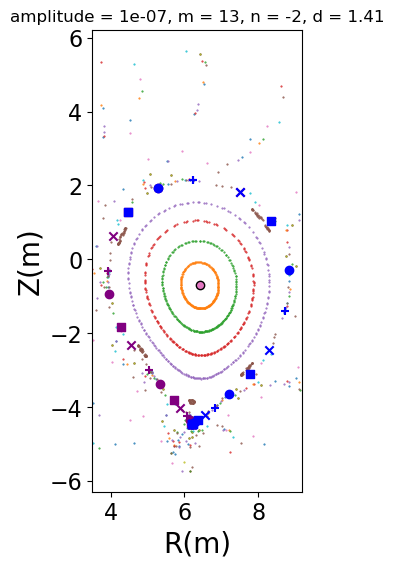

In [73]:
hs_1 = manifold.integrate(manifold.rfp_s + eps_s_1 * manifold.vector_s, 7, -1)
hs_2 = manifold.integrate(manifold.rfp_s + eps_s_2 * manifold.vector_s, 7, -1)
hs_3 = manifold.integrate(manifold.rfp_s + eps_s_3 * manifold.vector_s, 7, -1)
hs_4 = manifold.integrate(manifold.rfp_s + eps_s_4 * manifold.vector_s, 7, -1)

hu_1 = manifold.integrate(manifold.rfp_u + eps_u_1 * manifold.vector_u, 6, 1)
hu_2 = manifold.integrate(manifold.rfp_u + eps_u_2 * manifold.vector_u, 6, 1)
hu_3 = manifold.integrate(manifold.rfp_u + eps_u_3 * manifold.vector_u, 6, 1)
hu_4 = manifold.integrate(manifold.rfp_u + eps_u_4 * manifold.vector_u, 6, 1)

ax.scatter(hs_1[0,:], hs_1[1,:], marker="x", color="purple", zorder=10)
ax.scatter(hs_2[0,:], hs_2[1,:], marker="+", color="purple", zorder=10)
ax.scatter(hs_3[0,:], hs_3[1,:], marker="o", color="purple", zorder=10)
ax.scatter(hs_4[0,:], hs_4[1,:], marker="s", color="purple", zorder=10)

ax.scatter(hu_1[0,:], hu_1[1,:], marker="x", color="blue", zorder=10)
ax.scatter(hu_2[0,:], hu_2[1,:], marker="+", color="blue", zorder=10)
ax.scatter(hu_3[0,:], hu_3[1,:], marker="o", color="blue", zorder=10)
ax.scatter(hu_4[0,:], hu_4[1,:], marker="s", color="blue", zorder=10)

fig

In [58]:
print("\nComputing the manifold\n")
manifold.compute(nintersect = 9, neps = 300, epsilon=1e-7)
# manifold.compute(nintersect = 9, neps = 100, epsilon=1e-6, directions="s+")
# manifold.compute(nintersect = 7, neps = 1, epsilon=1e-7, directions="u+")
# manifold.compute(nintersect = 7, neps = 1, epsilon=1e-6, directions="s+")


Computing the manifold

Computing unstable manifold with postive epsilon...
Computing stable manifold with positive epsilon...


In [74]:
print("\nPlotting the manifold")
manifold.plot(ax, directions="u+s+")
# ax.set_title(f"amplitude = {maxwellboltzmann['amplitude']}, m = {maxwellboltzmann['m']}, n = {maxwellboltzmann['n']}, d = {maxwellboltzmann['d']:.2f}")


Plotting the manifold


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'amplitude = 1e-07, m = 13, n = -2, d = 1.41'}, xlabel='R(m)', ylabel='Z(m)'>)

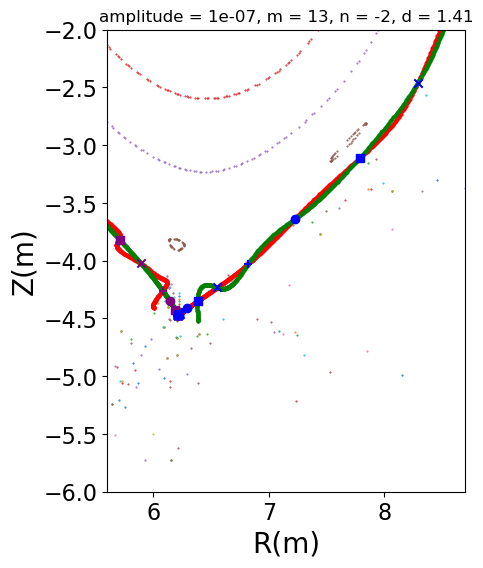

In [78]:
# ax.set_xlim(5.6, 7.5)
# ax.set_ylim(-6, -3)

ax.set_xlim(5.6, 8.7)
ax.set_ylim(-6, -2)

fig